In [1]:
import pandas as pd
from pathlib import Path
import inspect 

import datetime
import os
import shutil
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.ticker import MaxNLocator

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import pickle
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from night.piae_sde_sampling import *
from night.piae_sde import *
from night.piae_reg import *
from night.piae_reg_sampling import *
from night.ae import *

from dataset import ClimateDataset



from utils import *



In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

No GPU. Running on CPU


In [3]:
device = "mps"

## Research Notes and Progress

**Current Status**
1. Should we do $X_{t0} \rightarrow NEE_{t1}$ instead of current $X_{t0} \rightarrow NEE_{t0}$ and see if we beat RFR at this
2. MSE experiments
3. Architecture experiments

In [4]:
save_dir = Path("Final Experiments")

In [5]:
config = DotMap({"flux_model": "night"})

In [6]:
writer = SummaryWriter(save_dir.joinpath("tensorboard"))

## Model Building and Training

### Data

In [7]:
data = pd.read_parquet("../data_manipulation/final_night_data.parquet")

In [8]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

def physics_nee(k, T, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    NEE = rb * exp_term
    return NEE

In [9]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [10]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [11]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [12]:
data.shape

(21535, 76)

In [13]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [14]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

In [15]:
data["NEE_phy"] = physics_nee(data[["E0", "rb"]].values, data.Ta.values)

### Noise Distribution and Calculating diffusion coefficient $\sigma_{night}$

In [16]:
phy_error = data.NEE - data.NEE_phy
noise_mu = np.mean(phy_error)
noise_std = np.std(phy_error)

### Training Data 

In [17]:
train_data, test_data = split_data(data)

In [18]:
X_train = train_data[drivers]
NEE_train = train_data["NEE_next"]
T_train = train_data["Ta"]
dT_train = train_data["dTa"]
dNEE_train = train_data["dNEE"]
bNEE_train = train_data["NEE"]
K_train = train_data[["E0", "rb"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE_next"]
T_test = train_data["Ta"]
dT_test = test_data["dTa"]
dNEE_test = test_data["dNEE"]
bNEE_test = test_data["NEE"]
K_test = test_data[["E0", "rb"]]


In [19]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [20]:
with open(save_dir.joinpath("normalizer.pickle"), "wb") as fp:
    pickle.dump(normalizer, fp)

In [21]:
config.data.X = drivers.tolist()
config.data.train_size = X_train.shape[0]
config.data.train_start_date = train_data["DateTime"].iloc[0].ctime()
config.data.train_end_date = train_data["DateTime"].iloc[-1].ctime()
config.data.test_size = X_test.shape[0]
config.data.test_start_date = test_data["DateTime"].iloc[0].ctime()
config.data.test_end_date = test_data["DateTime"].iloc[-1].ctime()


### Model Building

In [22]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        nn.init.xavier_uniform_(layer.weight)
        #init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

### Training Setup

In [23]:
def evaluate(gt, preds, exp_save_dir):
    results = DotMap({'mmd': {}, 'wasstn': {}, 'kl': {}, 'mae': {}, 'r2': {}})
    print(colored("Metrics ", "red"))
    for col in gt:
        print(col)
        mmd = compute_mmd(gt[col], preds[col])
        wasstn = wasserstein_distance(gt[col], preds[col])
        kl = compute_kl_divergence(gt[col], preds[col])
        mae = mean_absolute_error(gt[col], preds[col])
        r2 = r2_score(gt[col]
                      , preds[col])
        print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
        config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
        config.eval.r2[col] = r2_score(gt[col], preds[col])
        results.mmd[col] = mmd
        results.wasstn[col] = wasstn
        results.kl[col] = kl
        results.mae[col] = mae
        results.r2[col] = r2
    
    with open(exp_save_dir.joinpath("config.json"), "w") as fp:
        json.dump(config.toDict(), fp)
    return results

# PIAE_SDE_Sampling

In [24]:
all_results = []

seeds = [0, 41, 123, 255, 999]
for seed in seeds:
    print(f"Experimenting for seed {seed}")
    torch.manual_seed(seed)
    
    lr = 1e-3
    exp_save_dir = save_dir.joinpath("PIAE_SDE_Sampling"+str(seed))

    if exp_save_dir.exists():
        shutil.rmtree(exp_save_dir)
    os.makedirs(exp_save_dir.as_posix())

    best_test_loss = float('inf')
    best_model_path = exp_save_dir.joinpath('best_model.pth')
    
    model = PIAE_SDE_Sampling_Model(input_dim=X_train.shape[1] + 3, latent_dim=32, encoder_dims=[16, 16], decoder_dims = [16, 16], activation=nn.ReLU)
    model.apply(initialize_weights)
    with open(exp_save_dir.joinpath("model.txt"), "w") as fp:
        fp.write(str(model))
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
    train_dataset = ClimateDataset(X_train, K_train.values, T_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, NEE_train.values)
    test_dataset = ClimateDataset(X_test, K_test.values, T_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, NEE_test.values)
    
    # Create a DataLoader instance
    train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)  

    loss_fn = nn.MSELoss()
    loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"

    config.model.activation = str(model.activation)
    config.model.lr = lr
    config.model.loss_fn = str(loss_fn)
    
    num_epochs = 150
    patience = 50
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)
    
    config.training.patience = patience
    config.training.num_epochs = num_epochs
    
    trainer = PIAE_SDE_Sampling_Trainer(optimizer, scheduler, writer, device="mps")
    
    
    with open(exp_save_dir.joinpath("loss_function.txt"), "w") as fp:
        fp.write(inspect.getsource(trainer.loss_function))

    with open(exp_save_dir.joinpath("config.json"), "w") as fp:
        json.dump(config.toDict(), fp)

    mse_factor = 1
    mmd_factor = 1
    f_factor = 1

    trainer.train(model, loss_fn, train_data_loader, test_data_loader, noise_std, noise_mu, num_epochs,
              best_model_path, f_factor, mse_factor, mmd_factor)

    model.load_state_dict(torch.load(f"{exp_save_dir}/best_model.pth", weights_only=True)) if exp_save_dir.joinpath("best_model.pth").exists() else None

    gt, preds = trainer.predict(model, test_data_loader)
    results = evaluate(gt, preds, exp_save_dir)
    all_results.append(results)

Experimenting for seed 0
[Linear(in_features=18, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=32, bias=True)]
Epoch: 0



KeyboardInterrupt



### Standard Errors

In [ ]:
metrics = ['mmd', 'wasstn', 'kl', 'mae', 'r2']

for metric in metrics:
    std_error = dict({'nee': 0.0, 'E0': 0.0, 'rb': 0.0, 'dtemp': 0.0, 'f': 0.0})
    mean_error = dict({'nee': 0.0, 'E0': 0.0, 'rb': 0.0, 'dtemp': 0.0, 'f': 0.0})
    for var in std_error:
        metric_values = [] 
        for result in all_results:
            metric_values.append(result[metric][var])
        std = np.std(metric_values)
        mean = np.mean(metric_values)
        std_error[var] = std / np.sqrt(len(all_results))
        mean_error[var] = mean
    print(metric, "\nMean: ", mean_error, "\nStd Error", std_error)
        

# PIAE_SDE_Reg_Sampling

In [25]:
all_results = []

seeds = [0, 41, 123, 255, 999]
for seed in seeds:
    print(f"Experimenting for seed {seed}")
    torch.manual_seed(seed)
    
    lr = 1e-3
    exp_save_dir = save_dir.joinpath("PIAE_SDE_Reg_Sampling"+str(seed))

    if exp_save_dir.exists():
        shutil.rmtree(exp_save_dir)
    os.makedirs(exp_save_dir.as_posix())

    best_test_loss = float('inf')
    best_model_path = exp_save_dir.joinpath('best_model.pth')
    
    model = PIAE_SDE_Reg_Sampling_Model(input_dim=X_train.shape[1] + 3, latent_dim=32, encoder_dims=[16, 16], decoder_dims = [16, 16], activation=nn.ReLU)
    model.apply(initialize_weights)
    with open(exp_save_dir.joinpath("model.txt"), "w") as fp:
        fp.write(str(model))
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
    train_dataset = ClimateDataset(X_train, K_train.values, T_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, NEE_train.values)
    test_dataset = ClimateDataset(X_test, K_test.values, T_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, NEE_test.values)
    
    # Create a DataLoader instance
    train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)  

    loss_fn = nn.MSELoss()
    loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"

    config.model.activation = str(model.activation)
    config.model.lr = lr
    config.model.loss_fn = str(loss_fn)
    
    num_epochs = 150
    patience = 20
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)
    
    config.training.patience = patience
    config.training.num_epochs = num_epochs
    
    trainer = PIAE_SDE_Reg_Sampling_Trainer(optimizer, scheduler, writer, device="mps")
    
    
    with open(exp_save_dir.joinpath("loss_function.txt"), "w") as fp:
        fp.write(inspect.getsource(trainer.loss_function))

    with open(exp_save_dir.joinpath("config.json"), "w") as fp:
        json.dump(config.toDict(), fp)

    mse_factor = 1
    mmd_factor = 1
    f_factor = 1

    trainer.train(model, loss_fn, train_data_loader, test_data_loader, noise_std, noise_mu, num_epochs,
              best_model_path, f_factor, mse_factor, mmd_factor)

    model.load_state_dict(torch.load(f"{exp_save_dir}/best_model.pth", weights_only=True)) if exp_save_dir.joinpath("best_model.pth").exists() else None

    gt, preds = trainer.predict(model, test_data_loader)
    results = evaluate(gt, preds, exp_save_dir)
    all_results.append(results)

Experimenting for seed 0
[Linear(in_features=18, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=32, bias=True)]
Epoch: 0
Training Loss: 3324.90771484375
mse_loss_nee 6.9742026 mmd_loss_nee 0.23466524 mse_loss_E0 3303.1196 mse_loss_rb 10.41185 mse_temp_loss 2.7435975 physics_loss 0.0 noise_loss 1.2782072 mse_f_loss 0.14589396 

Test Loss: 35.62492752075195
mse_loss_nee 3.79135 mmd_loss_nee 0.0287438 mse_loss_E0 28.119867 mse_loss_rb 5.839819 mse_temp_loss 0.0050387997 physics_loss 0.0 noise_loss 1.3034557 mse_f_loss 0.007974941 


New best model saved at epoch 1 with test loss: 35.6249
Epoch: 1
Training Loss: 26.451324462890625
mse_loss_nee 3.6167235 mmd_loss_nee 0.035743877 mse_loss_E0 17.8537 mse_loss_rb 3.5481243 mse_temp_loss 0.01025975 physics_loss 0.0 noise_loss 1.3074331 mse_f_loss 0.079337895 

Test Loss: 22.94612693786621
mse_loss_nee 3.712178 mmd_loss_nee 0.024305694 mse_loss_E0 8.550382 mse_

### Standard Errors

In [26]:
metrics = ['mmd', 'wasstn', 'kl', 'mae', 'r2']

for metric in metrics:
    std_error = dict({'nee': 0.0, 'E0': 0.0, 'rb': 0.0, 'dtemp': 0.0, 'f': 0.0})
    mean_error = dict({'nee': 0.0, 'E0': 0.0, 'rb': 0.0, 'dtemp': 0.0, 'f': 0.0})
    for var in std_error:
        metric_values = [] 
        for result in all_results:
            metric_values.append(result[metric][var])
        std = np.std(metric_values)
        mean = np.mean(metric_values)
        std_error[var] = std / np.sqrt(len(all_results))
        mean_error[var] = mean
    print(metric, "\nMean: ", mean_error, "\nStd Error", std_error)
        

mmd 
Mean:  {'nee': 0.03484763968660751, 'E0': 0.011552005209566032, 'rb': 0.027954387509965595, 'dtemp': 0.01691220199724968, 'f': 0.012114777258618281} 
Std Error {'nee': 0.002119204506060917, 'E0': 0.0019222646333682918, 'rb': 0.005765916023838383, 'dtemp': 0.008978474720607938, 'f': 0.004871426695960512}
wasstn 
Mean:  {'nee': 0.19388286253262882, 'E0': 0.05687940553770922, 'rb': 0.08166133745450589, 'dtemp': 0.0367916633765331, 'f': 0.016611272637290352} 
Std Error {'nee': 0.008957737879169349, 'E0': 0.010062314376948997, 'rb': 0.014593002595005936, 'dtemp': 0.013298910408120057, 'f': 0.0021056340850732318}
kl 
Mean:  {'nee': 0.109732821063061, 'E0': 0.1366896219093005, 'rb': 0.7894584517496359, 'dtemp': 0.6877322922664247, 'f': 0.31458514065843085} 
Std Error {'nee': 0.0150934372678849, 'E0': 0.03412375788668431, 'rb': 0.14650086631296133, 'dtemp': 0.14573253294519734, 'f': 0.05643653845262705}
mae 
Mean:  {'nee': 0.8670894881151261, 'E0': 0.05796674159471209, 'rb': 0.10802609024

# Auto Encoder

In [25]:
all_results = []

seeds = [0, 41, 123, 255, 999]
for seed in seeds:
    print(f"Experimenting for seed {seed}")
    torch.manual_seed(seed)
    
    lr = 1e-3
    exp_save_dir = save_dir.joinpath("AE"+str(seed))

    if exp_save_dir.exists():
        shutil.rmtree(exp_save_dir)
    os.makedirs(exp_save_dir.as_posix())

    best_test_loss = float('inf')
    best_model_path = exp_save_dir.joinpath('best_model.pth')
    
    model = AE_Model(input_dim=X_train.shape[1] + 3, latent_dim=32, encoder_dims=[16, 16], decoder_dims = [16, 16], activation=nn.ReLU)
    model.apply(initialize_weights)
    with open(exp_save_dir.joinpath("model.txt"), "w") as fp:
        fp.write(str(model))
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
    train_dataset = ClimateDataset(X_train, K_train.values, T_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, NEE_train.values)
    test_dataset = ClimateDataset(X_test, K_test.values, T_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, NEE_test.values)
    
    # Create a DataLoader instance
    train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)  

    loss_fn = nn.MSELoss()
    loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"

    config.model.activation = str(model.activation)
    config.model.lr = lr
    config.model.loss_fn = str(loss_fn)
    
    num_epochs = 140
    patience = 20
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)
    
    config.training.patience = patience
    config.training.num_epochs = num_epochs
    
    trainer = AE_Trainer(optimizer, scheduler, writer, device="mps")
    
    
    with open(exp_save_dir.joinpath("loss_function.txt"), "w") as fp:
        fp.write(inspect.getsource(trainer.loss_function))

    with open(exp_save_dir.joinpath("config.json"), "w") as fp:
        json.dump(config.toDict(), fp)

    mse_factor = 1
    mmd_factor = 1
    f_factor = 1

    trainer.train(model, loss_fn, train_data_loader, test_data_loader, num_epochs, best_model_path)

    model.load_state_dict(torch.load(f"{exp_save_dir}/best_model.pth", weights_only=True)) if exp_save_dir.joinpath("best_model.pth").exists() else None

    gt, preds = trainer.predict(model, test_data_loader)
    results = evaluate(gt, preds, exp_save_dir)
    all_results.append(results)

Experimenting for seed 0
Training Loss: 4838.77880859375
mse_loss_nee 364.71762 mse_loss_E0 4368.35 mse_loss_rb 105.71127 

Test Loss: 331.7987365722656
mse_loss_nee 316.34445 mse_loss_E0 10.201033 mse_loss_rb 5.253241 


New best model saved at epoch 1 with test loss: 331.7987
Training Loss: 429.42291259765625
mse_loss_nee 411.62805 mse_loss_E0 9.72352 mse_loss_rb 8.071365 

Test Loss: 234.80979919433594
mse_loss_nee 226.43752 mse_loss_E0 1.8130288 mse_loss_rb 6.559271 


Training Loss: 302.3504638671875
mse_loss_nee 294.3199 mse_loss_E0 3.6004653 mse_loss_rb 4.4301 

Test Loss: 166.7277374267578
mse_loss_nee 158.49419 mse_loss_E0 2.2224889 mse_loss_rb 6.0110636 


Training Loss: 208.8201446533203
mse_loss_nee 201.70735 mse_loss_E0 2.7634196 mse_loss_rb 4.349355 

Test Loss: 117.53424072265625
mse_loss_nee 109.72422 mse_loss_E0 1.491054 mse_loss_rb 6.318958 


Training Loss: 145.65196228027344
mse_loss_nee 139.87093 mse_loss_E0 1.5481547 mse_loss_rb 4.2328844 

Test Loss: 85.524345397

### Standard Errors

In [30]:
metrics = ['mmd', 'wasstn', 'kl', 'mae', 'r2']

for metric in metrics:
    std_error = dict({'nee': 0.0, 'E0': 0.0, 'rb': 0.0})
    mean_error = dict({'nee': 0.0, 'E0': 0.0, 'rb': 0.0})
    for var in std_error:
        metric_values = [] 
        for result in all_results:
            metric_values.append(result[metric][var])
        std = np.std(metric_values)
        mean = np.mean(metric_values)
        std_error[var] = std / np.sqrt(len(all_results))
        mean_error[var] = mean
    print(metric, "\nMean: ", mean_error, "\nStd Error", std_error)
        

mmd 
Mean:  {'nee': 0.04975606690772625, 'E0': 0.011172978433548732, 'rb': 0.014202849047211558} 
Std Error {'nee': 0.0015576775249018647, 'E0': 0.0033145872703314334, 'rb': 0.0034924187718596094}
wasstn 
Mean:  {'nee': 0.18596392627627392, 'E0': 0.044743825828596026, 'rb': 0.051408980607302625} 
Std Error {'nee': 0.008252451357537985, 'E0': 0.009067483739825077, 'rb': 0.011049683332918605}
kl 
Mean:  {'nee': 0.21045082094846598, 'E0': 0.11204690684841287, 'rb': 0.497096254804782} 
Std Error {'nee': 0.013137765109017962, 'E0': 0.03229988334110418, 'rb': 0.07877453443544302}
mae 
Mean:  {'nee': 0.8393279764138832, 'E0': 0.04670419401238115, 'rb': 0.056912188781834926} 
Std Error {'nee': 0.0013108844883147786, 'E0': 0.01013918911666305, 'rb': 0.010808262783452673}
r2 
Mean:  {'nee': 0.7460569937338831, 'E0': 0.9999690551981434, 'rb': 0.9976403785971387} 
Std Error {'nee': 0.0010181596668171085, 'E0': 1.555601510682473e-05, 'rb': 0.0008279013923012399}


## Random Forest

In [137]:
seeds = [0, 41, 123, 255, 999]
all_results_rfr = []
for seed in seeds:
    results = DotMap({})
    print(f"Experimenting for seed {seed}")
    torch.manual_seed(seed)
    input_rfr = np.concatenate((X_train, train_data[['NEE', 'E0', 'rb']].values), axis=1)  # list(range(0, 15)) + [16, 17]
    rfr = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rfr.fit(input_rfr, NEE_train)
    input_rfr = np.concatenate((X_test, test_data[['NEE', 'E0', 'rb']].values), axis=1)
    preds_rfr = rfr.predict(input_rfr)
    gt_rfr = NEE_test.values
    mmd = compute_mmd(gt_rfr, preds_rfr)
    wasstn = wasserstein_distance(gt_rfr, preds_rfr)
    kl = compute_kl_divergence(gt_rfr, preds_rfr)
    mae = mean_absolute_error(gt_rfr, preds_rfr)
    r2 = r2_score(gt_rfr, preds_rfr)
    results.mmd = mmd
    results.wasstn = wasstn
    results.kl = kl
    results.mae = mae
    results.r2 = r2
    print(colored("NEE", "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    all_results_rfr.append(results)
    

Experimenting for seed 0
NEE 
MMD: 0.061118153249880396, Wasstn: 0.24108980663479912, KL: 0.2387293329953831, MAE: 0.9011970755688335, R2: 0.7250920823509102
Experimenting for seed 41
NEE 
MMD: 0.05239841958599001, Wasstn: 0.23734642718212232, KL: 0.26564526476152306, MAE: 0.904992775504302, R2: 0.7185184940250569
Experimenting for seed 123
NEE 
MMD: 0.05362524321852251, Wasstn: 0.2339375440368069, KL: 0.23966055660620772, MAE: 0.9029610580951242, R2: 0.7197247825054605
Experimenting for seed 255
NEE 
MMD: 0.05584407364695981, Wasstn: 0.23792723444072647, KL: 0.23047239977689954, MAE: 0.9049117614483746, R2: 0.7177520094340011
Experimenting for seed 999
NEE 
MMD: 0.05231822296381046, Wasstn: 0.2358054424020076, KL: 0.23358634105880188, MAE: 0.8933942983389102, R2: 0.7270111002985866


#### Standard Errors

In [140]:
metrics = ['mmd', 'wasstn', 'kl', 'mae', 'r2']
for metric in metrics:
    metric_values = [] 
    for result in all_results_rfr:
        metric_values.append(result[metric])
    std = np.std(metric_values)
    mean = np.mean(metric_values)
    std_error = std / np.sqrt(len(all_results))
    print(metric, mean, std_error)
        

mmd 0.05506082253303264 0.0014693654077662759
wasstn 0.23722129093929248 0.0010633353148087037
kl 0.2416187790397631 0.005579309563987935
mae 0.9014913937911089 0.0019159131499818043
r2 0.721619693722803 0.0016648346163480308


## XGB

In [142]:
seeds = [0, 41, 123, 255, 999]
all_results_xgb = []
for seed in seeds:
    results = DotMap({})
    print(f"Experimenting for seed {seed}")
    torch.manual_seed(seed)
    input_rfr = np.concatenate((X_train, train_data[['NEE', 'E0', 'rb']].values), axis=1)  # list(range(0, 15)) + [16, 17]
    rfr = XGBRegressor(n_estimators=100, random_state=seed, n_jobs=-1)
    rfr.fit(input_rfr, NEE_train)
    input_rfr = np.concatenate((X_test, test_data[['NEE', 'E0', 'rb']].values), axis=1)
    preds_rfr = rfr.predict(input_rfr)
    gt_rfr = NEE_test.values
    mmd = compute_mmd(gt_rfr, preds_rfr)
    wasstn = wasserstein_distance(gt_rfr, preds_rfr)
    kl = compute_kl_divergence(gt_rfr, preds_rfr)
    mae = mean_absolute_error(gt_rfr, preds_rfr)
    r2 = r2_score(gt_rfr, preds_rfr)
    results.mmd = mmd
    results.wasstn = wasstn
    results.kl = kl
    results.mae = mae
    results.r2 = r2
    print(colored("NEE", "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    all_results_xgb.append(results)
    

Experimenting for seed 0
NEE 
MMD: 0.052352936667433, Wasstn: 0.20205098003111185, KL: 0.21689917392301125, MAE: 0.9875612285772472, R2: 0.6585242786548966
Experimenting for seed 41
NEE 
MMD: 0.052352936667433, Wasstn: 0.20205098003111185, KL: 0.21689917392301125, MAE: 0.9875612285772472, R2: 0.6585242786548966
Experimenting for seed 123
NEE 
MMD: 0.052352936667433, Wasstn: 0.20205098003111185, KL: 0.21689917392301125, MAE: 0.9875612285772472, R2: 0.6585242786548966
Experimenting for seed 255
NEE 
MMD: 0.052352936667433, Wasstn: 0.20205098003111185, KL: 0.21689917392301125, MAE: 0.9875612285772472, R2: 0.6585242786548966
Experimenting for seed 999
NEE 
MMD: 0.052352936667433, Wasstn: 0.20205098003111185, KL: 0.21689917392301125, MAE: 0.9875612285772472, R2: 0.6585242786548966


#### Standard Errors

In [143]:
metrics = ['mmd', 'wasstn', 'kl', 'mae', 'r2']
for metric in metrics:
    metric_values = [] 
    for result in all_results_xgb:
        metric_values.append(result[metric])
    std = np.std(metric_values)
    mean = np.mean(metric_values)
    std_error = std / np.sqrt(len(all_results))
    print(metric, mean, std_error)
        

mmd 0.052352936667433 0.0
wasstn 0.20205098003111183 1.2412670766236365e-17
kl 0.21689917392301122 1.2412670766236365e-17
mae 0.987561228577247 4.965068306494546e-17
r2 0.6585242786548966 0.0


## Evaluation and Analysis

In [262]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 5).values

date = test_data.DateTime[mask].iloc[0]


gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten() 
preds_vis_raw = preds.nee[mask].flatten() - preds.noise[mask].flatten()
phy = test_data['NEE_phy'][mask].values.flatten() 

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
ax.plot(preds_vis_raw, 'go-', color="green", linewidth=4, markersize=8)
ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)

# Calculate final mean prediction
mean_prediction = preds_vis_raw + 

# Calculate prediction intervals
z_score = 1.96  # For 95% confidence
lower_bound = mean_prediction - z_score * preds.noise_stds[mask]
upper_bound = mean_prediction + z_score * preds.noise_stds[mask]


plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="95% Prediction Interval")


ax.legend(["Ground Truth", "Predictions", "Predictions without noise", "Phy"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

fig.savefig("piae_nee_night_daily.png", bbox_inches='tight')


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_12069/1948066264.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_12069/1948066264.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_12069/1948066264.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis_raw, 'go-', color="green", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_120

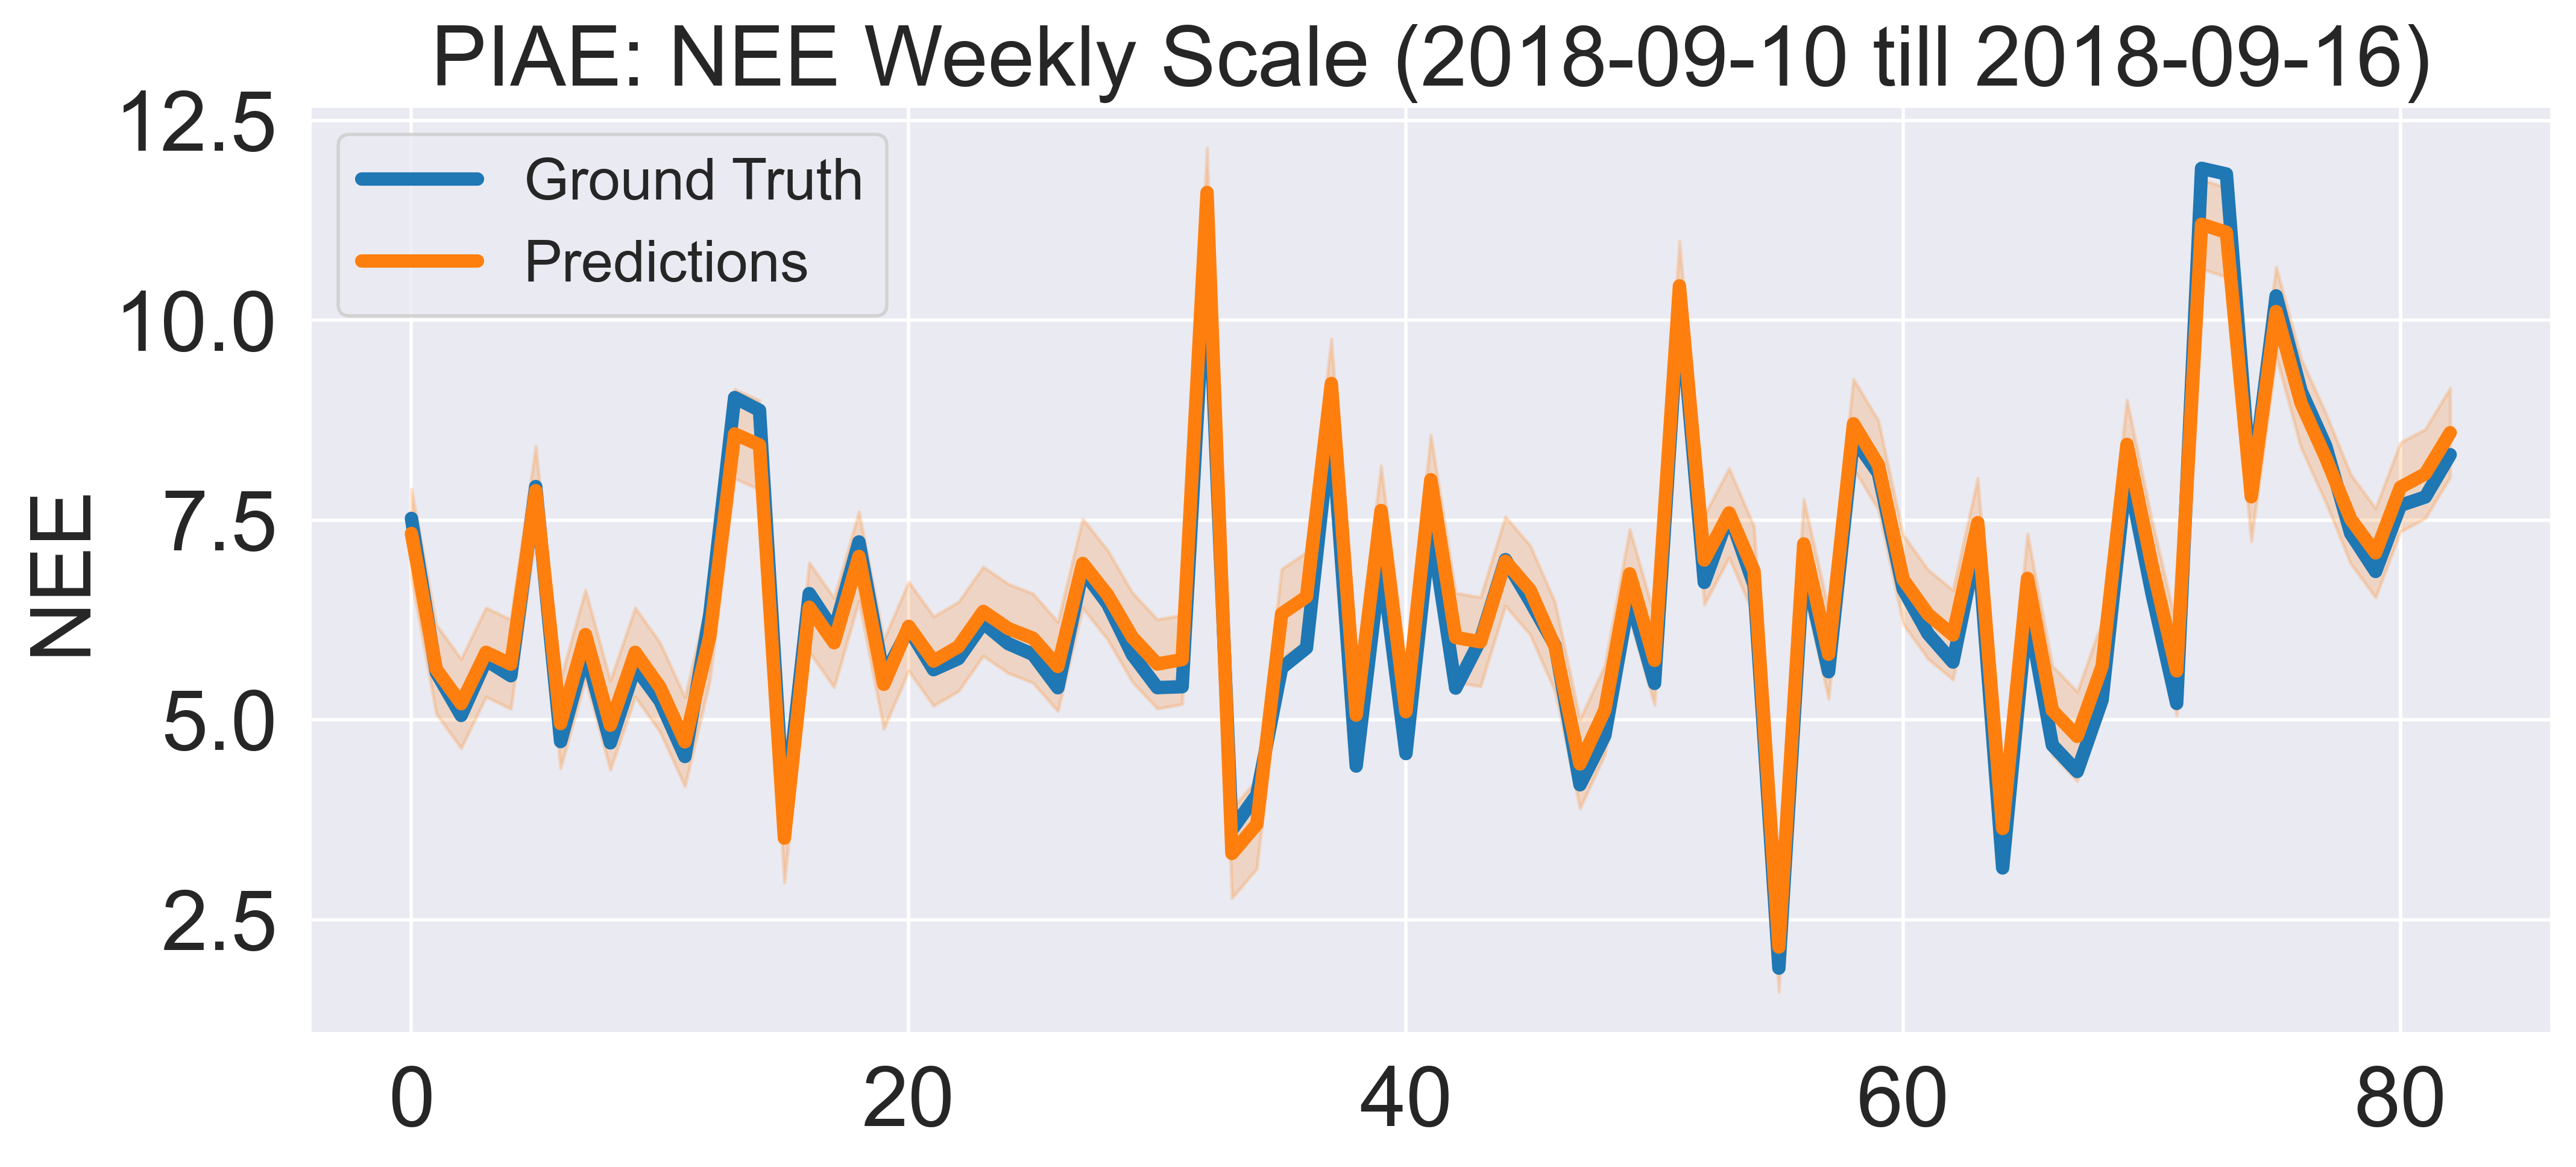

In [266]:
### Weekly

test_data['week_group'] = (test_data['dayofweek'] < test_data['dayofweek'].shift()).cumsum()

mask = test_data.week_group == 4

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()


fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, '-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, '-', color="#ff7f0e", linewidth=4, markersize=8)

residuals = gt_vis - preds_vis
sigma_residual = np.std(residuals, ddof=1)  # ddof=1 for unbiased estimator
z_score = 1.96  # 95% confidence interval
lower_bound = preds_vis - z_score * sigma_residual
upper_bound = preds_vis + z_score * sigma_residual

plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="95% Prediction Interval")


ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Weekly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_weekly.png", bbox_inches='tight')


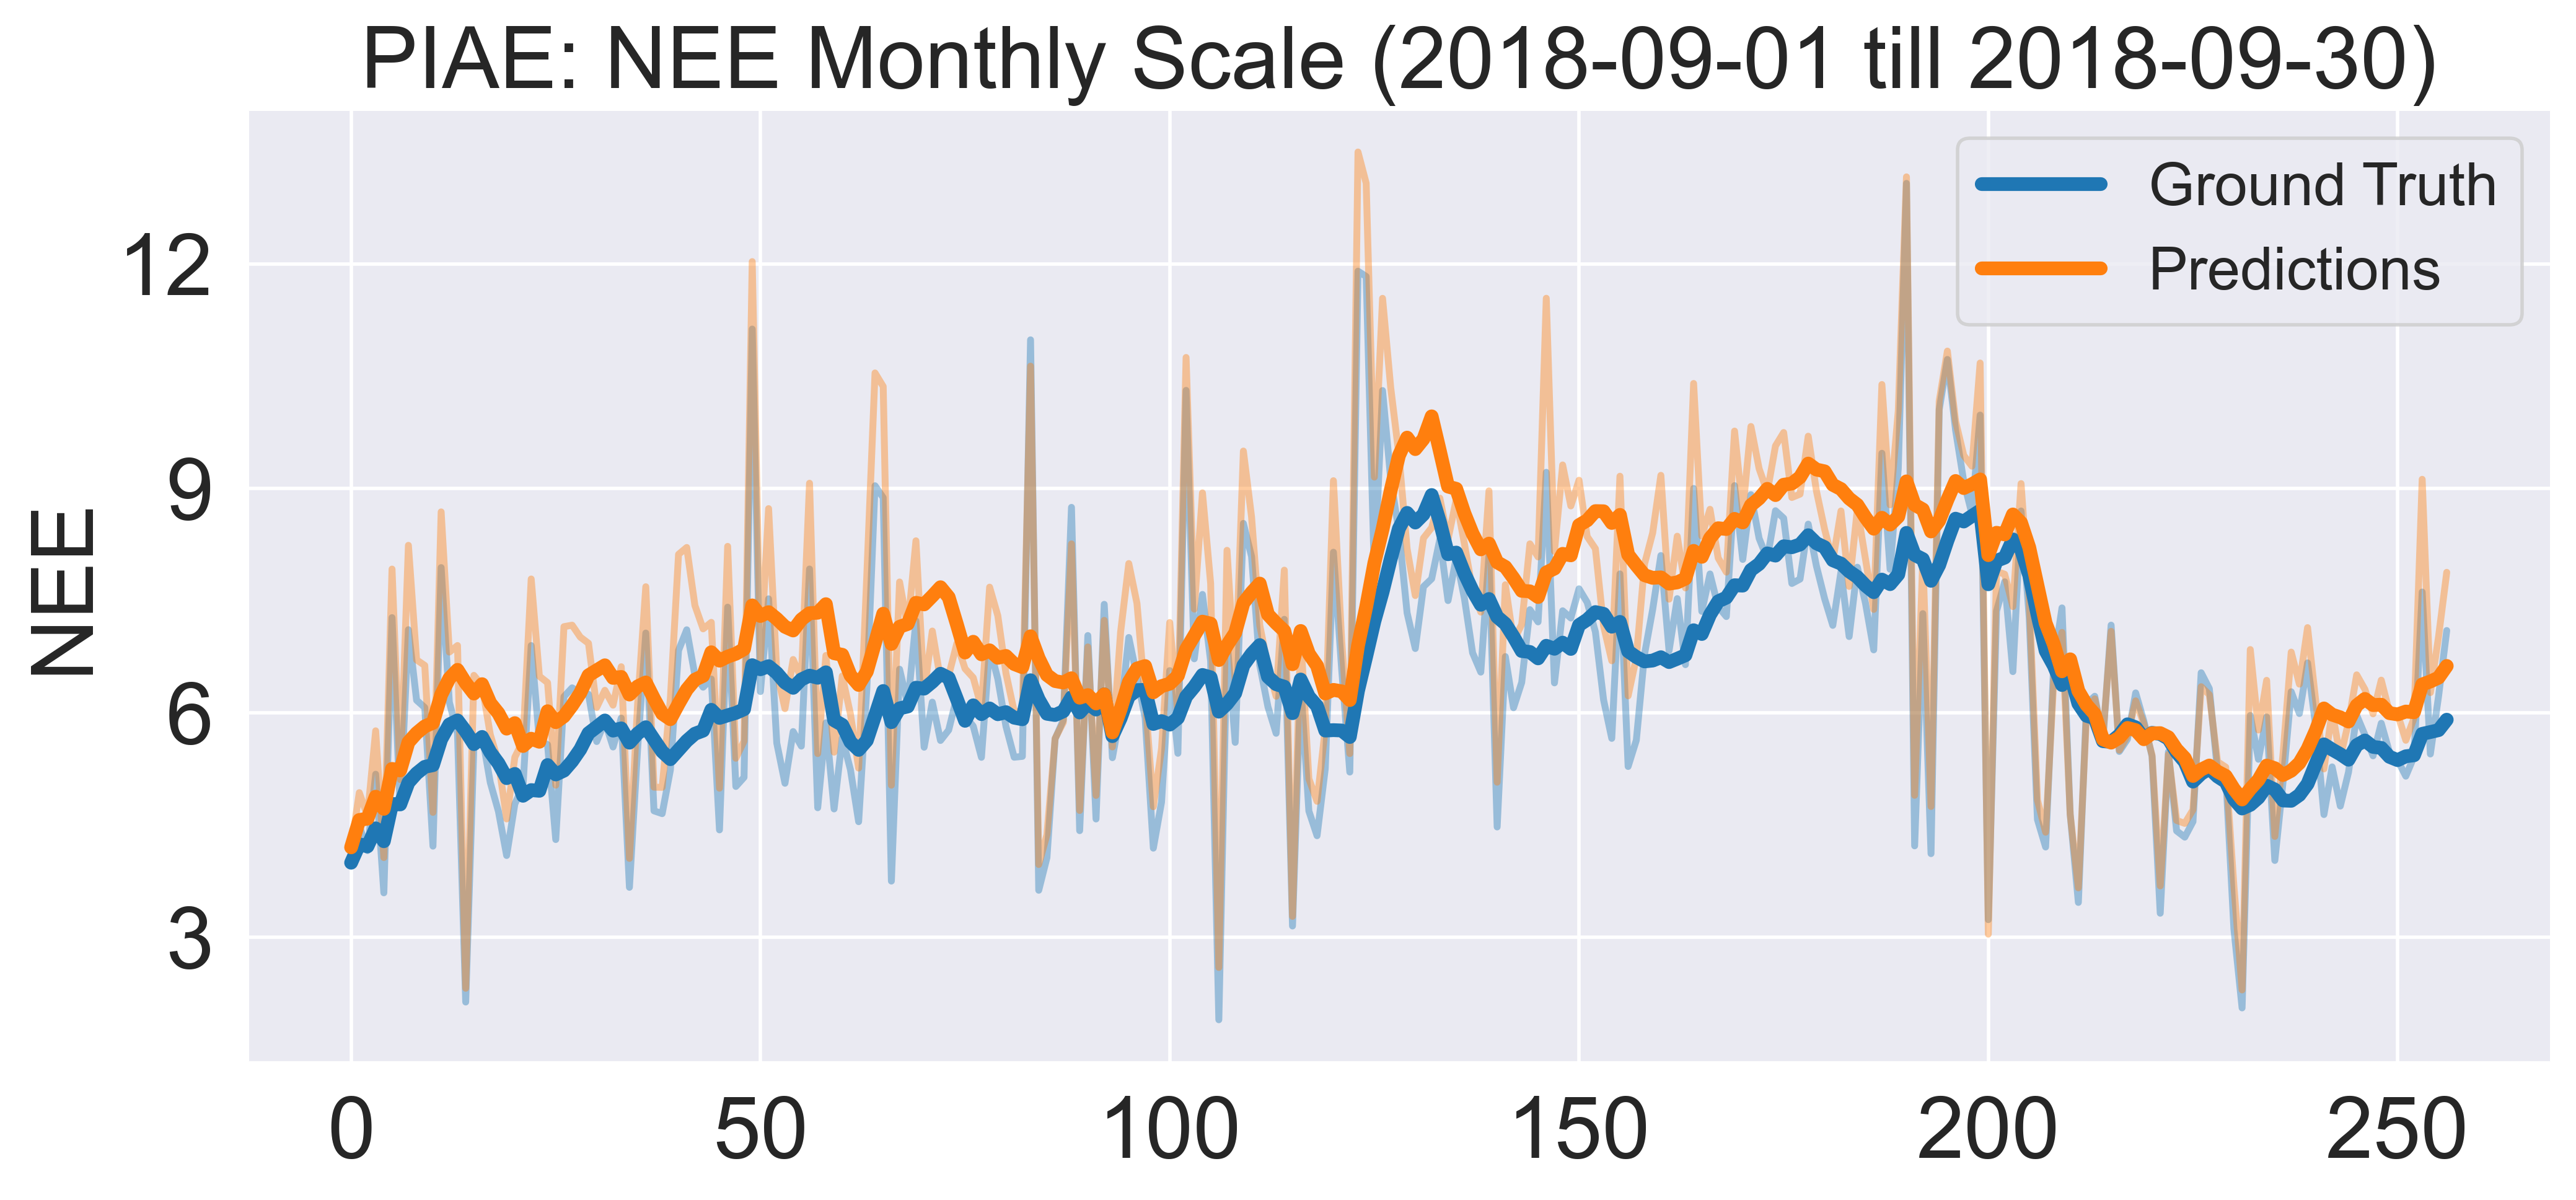

In [96]:
### Monthly

mask = (test_data.DateTime.dt.year == 2018) & (test_data.DateTime.dt.month == 9)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Monthly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_monthly.png", bbox_inches='tight')

In [98]:
### Quarterly

test_data.season.unique()

mask = (test_data.DateTime.dt.year == 2018) & (test_data.season == 4)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Quarterly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_quarterly.png", bbox_inches='tight')

## Training on MMD now for noise modelling

In [67]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [68]:
epoch = 0

##### Control Room

In [69]:
# CONTROL ROOM
loss_fn = MMD_loss()
for g in optimizer.param_groups:
    g['lr'] = 0.001

##### Back to training

In [71]:
model.eval()

PIAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=32, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (k_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=2, bias=True)
    (4): ReLU()
  )
)

In [72]:
preds = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": [], "z": []})
gt = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": []})


for batch in test_data_loader:
    x = batch['X'].to(device)
    k = batch['k'].to(device)
    f = batch['dNEE'].to(device)
    b = batch['bNEE'].to(device)
    dtemp = batch['dT'].to(device)
    nee = batch['NEE'].to(device)
            
    nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x)
    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.dtemp.extend(dT_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.f.extend(f_pred.cpu().detach().numpy().tolist())
    preds.z.extend(z.cpu().detach().numpy().tolist())
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.f.extend(f.cpu().detach().numpy().tolist())
    gt.dtemp.extend(dtemp.cpu().detach().numpy().tolist())

for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()

In [73]:
print(colored("Metrics ", "red"))
for col in gt:
    
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
    config.eval.r2[col] = r2_score(gt[col], preds[col])

with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee 
MMD: 0.04964816990187348, Wasstn: 0.13031518517728063, KL: 0.13335490986327686, MAE: 1.1115466750887566, R2: 0.574903199875495
E0 
MMD: 0.11021267201432779, Wasstn: 0.822791964784407, KL: 0.6077282486963288, MAE: 1.114507809195874, R2: 0.9975573571307922
rb 
MMD: 0.03777672466706936, Wasstn: 0.13905951634305838, KL: 0.6188039342107797, MAE: 0.2571809713231902, R2: 0.9792450210936386
dtemp 
MMD: 0.06941862133982124, Wasstn: 0.10504106700523719, KL: 2.475527204846719, MAE: 0.11218209476813679, R2: -929.5103831651008
f 
MMD: 0.0022951418296154025, Wasstn: 0.016919591604178393, KL: 0.7659079913367797, MAE: 0.03585930135793659, R2: -0.2379537721415972


In [133]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 1).values

date = test_data.DateTime[mask].iloc[0]
date = str(date).split(' ')[0]


gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

fig.savefig("piae_nee_night_daily.png", bbox_inches='tight')


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_21486/1391182150.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_21486/1391182150.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)


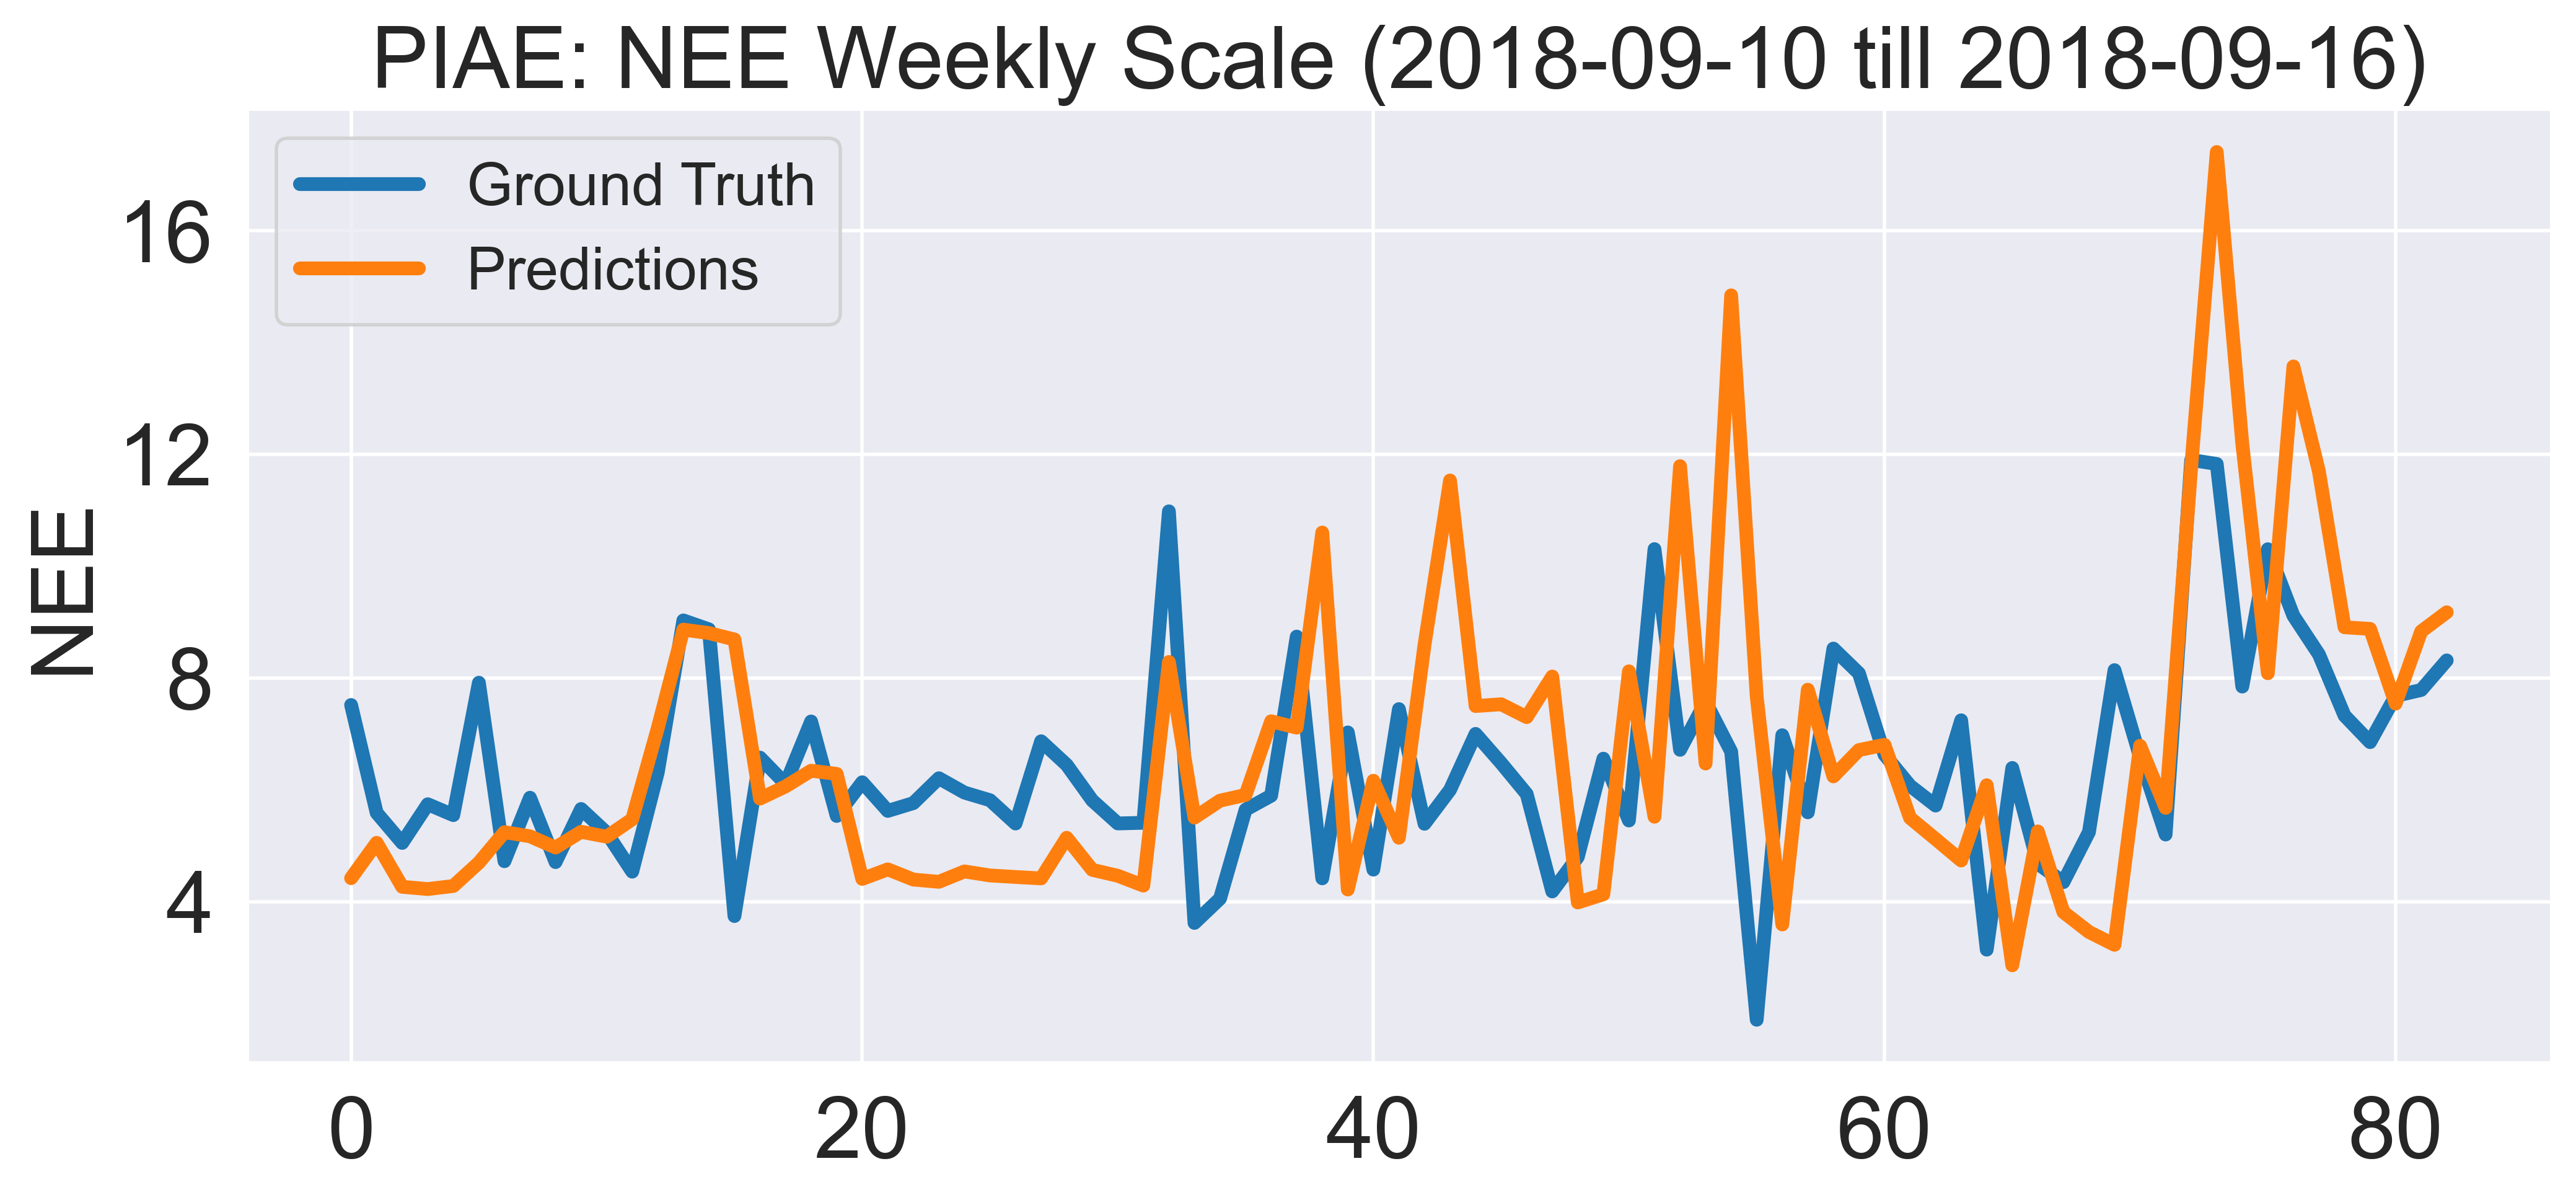

In [134]:
### Weekly

test_data['week_group'] = (test_data['dayofweek'] < test_data['dayofweek'].shift()).cumsum()

mask = test_data.week_group == 4

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, '-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, '-', color="#ff7f0e", linewidth=4, markersize=8)
ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Weekly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_weekly.png", bbox_inches='tight')


In [135]:
### Monthly

mask = (test_data.DateTime.dt.year == 2018) & (test_data.DateTime.dt.month == 9)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Monthly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_monthly.png", bbox_inches='tight')

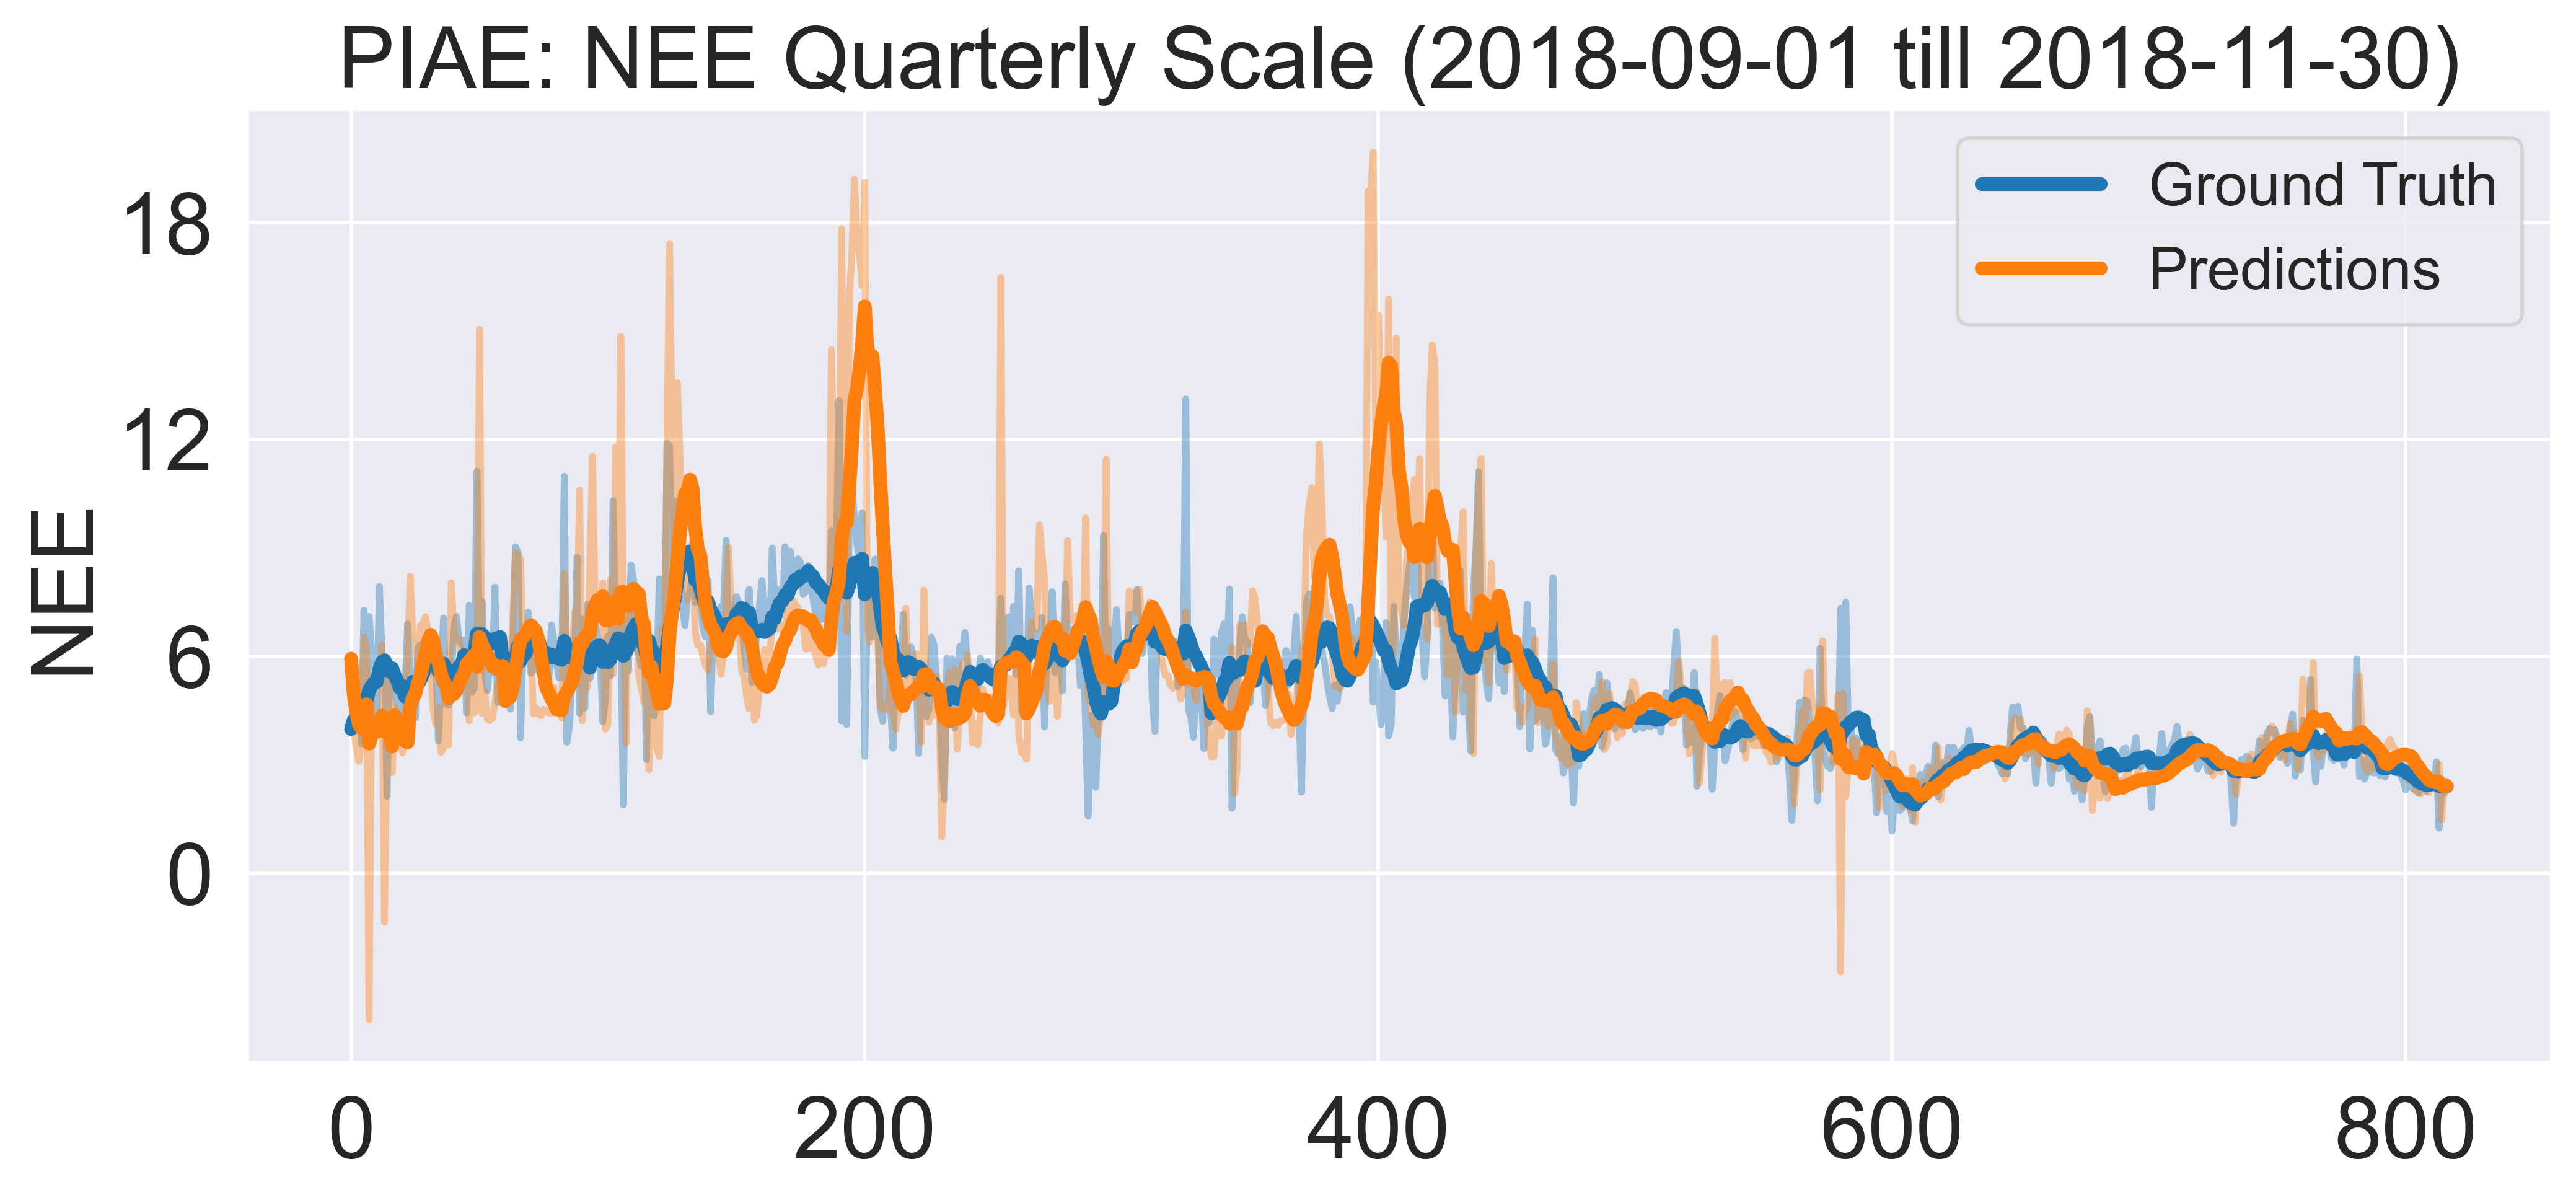

In [136]:
### Quarterly

test_data.season.unique()

mask = (test_data.DateTime.dt.year == 2018) & (test_data.season == 4)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Quarterly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_quarterly.png", bbox_inches='tight')